# Make sure that you are using the same version of python and sklearn for compatibility

In [1]:
from platform import python_version
print(python_version())
import sklearn
print((sklearn.__version__) )

3.9.13
1.2.1


In [4]:
import time
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pickle

## Load the saved models

In [5]:
# load the model from disk
filename = 'wrapper_ANN.sav'
ANN = pickle.load(open(filename, 'rb'))

filename = 'wrapper_KRR.sav'
KRR = pickle.load(open(filename, 'rb'))

filename = 'wrapper_RFR.sav'
RFR = pickle.load(open(filename, 'rb'))

filename = 'wrapper_SVR.sav'
SVR = pickle.load(open(filename, 'rb'))

## Function to plot the distance scaling

In [12]:
# plot distance scaling
def plot_dist_scaling(df_plot, predicted):
    # plt.figure(figsize = (8,7))
    color = ['purple','blue','green','yellow','red']
    styles = ['-','--','-.','-','--']
    d = list(set(df_plot['ClstD_km'].tolist()))
    d.sort()
    for m, j,style in zip(df_plot.Earthquake_Magnitude.unique(),color, styles):
        plt.loglog(d, np.exp(predicted[df_plot.Earthquake_Magnitude == m]), style, linewidth=3, color = j, label = 'M'+str(m))
       
    plt.legend()
    plt.xlabel('Rupture Distance (km)')
    plt.ylabel('PGA (g)')
    plt.ylim([0.000001, 10])
    plt.xlim([10, 1000])

## Function to create the dataframe for prediction

In [7]:
# function to create the data needed for plotting
# regions: Global, Alaska, Japan, Cascadia, Taiwan, CentralAmerica&Mexico, SouthAmerica
# tectonic: Interface or Intraslab
def data_for_plot(Vs: list, Ztor: list, tectonic = 'Interface', region = 'Alaska'):
    # M = list(np.linspace(5,8.5,8))
    M = list(np.arange(5,10,1))
    d = list(range(10,1000,5))
    List = [M, d, Ztor, Vs]

    combination = [p for p in itertools.product(*List)]

    df = pd.DataFrame(combination, columns =
                      ['Earthquake_Magnitude', 'ClstD_km', 'Ztor_km','Vs30_Selected_for_Analysis_m_s'],
                                               dtype = float) 
    df['Tectonic'] = tectonic
    df['DatabaseRegion'] = region
    return df

## Periods and weights of each individual model

In [8]:
# required columns from the processed data
periods = ['PGA_g','T0pt010S','T0pt020S','T0pt030S','T0pt050S','T0pt075S','T0pt100S','T0pt150S',
          'T0pt200S','T0pt250S','T0pt300S', 'T0pt400S','T0pt500S','T0pt750S','T1pt000S',
          'T1pt500S','T2pt000S','T3pt000S','T4pt000S','T5pt000S','T7pt500S','T10pt000S',
          'PGV_cm_sec','PGD_cm']

# wieght to combine different schemes: w0: RF, w1: NN, w2: KR, w3: SVR
w = [0.25, 0.25, 0.25, 0.25]    

# Prediction for interface events for a global version with VS30 = 400 m/s and Ztor = 10 km for PGA and PSA at 0.2 s

In [9]:
t0 = time.time()
df_plot = data_for_plot(Vs=[400], Ztor=[10], tectonic='Interface', region = 'Global')
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 20.25 s


Text(0.5, 1.0, 'PSA at 0.2 s - Interface - Global')

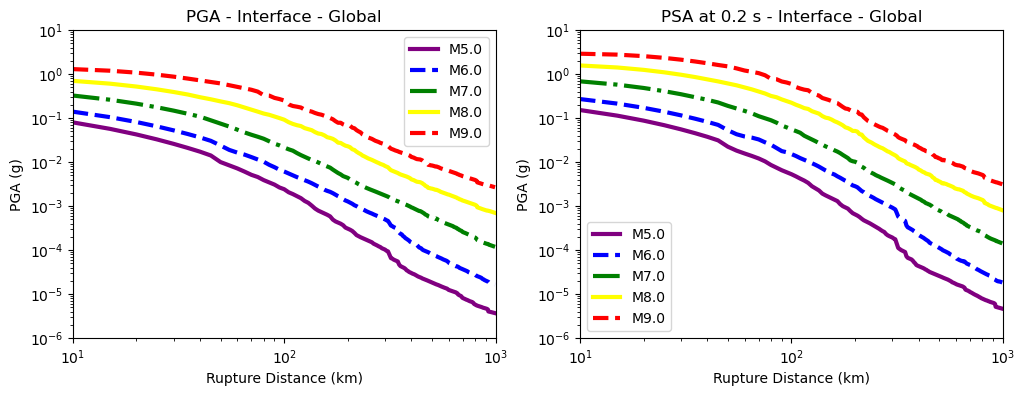

In [13]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA - Interface - Global')
plt.subplot(1,2,2)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,8])
plt.title('PSA at 0.2 s - Interface - Global')

# Prediction for intraslab events for Japan with VS30 = 760 m/s and Ztor = 20 km for PGA and PSA at 1.0 s

In [14]:
t0 = time.time()
df_plot = data_for_plot(Vs=[760], Ztor=[20], tectonic='Intraslab', region = 'Japan')
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 12.39 s


Text(0.5, 1.0, 'PSA at 1.0 s - Intraslab - Japan')

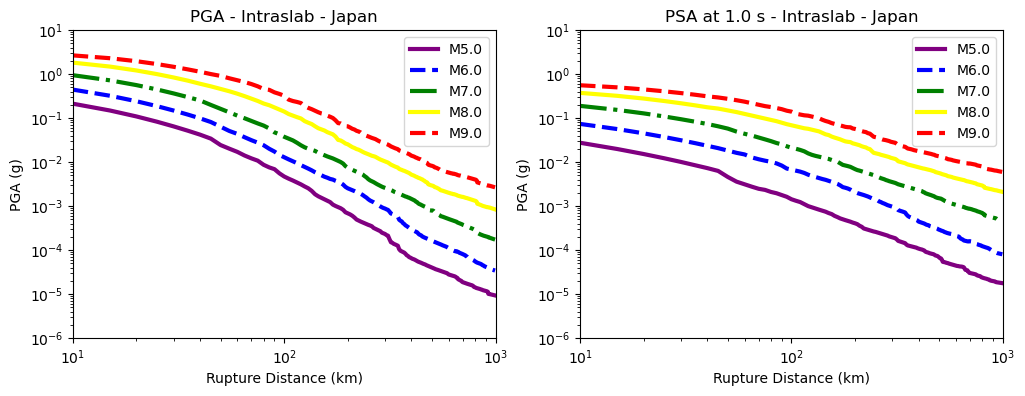

In [15]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA - Intraslab - Japan')
plt.subplot(1,2,2)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,14])
plt.title('PSA at 1.0 s - Intraslab - Japan')